In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scripts import bookdatafunctions as bdf
from pprint import pprint
from collections import Counter

In [2]:
DATA_FILE_AGES = "Data/FCBLex_data_output_ages.xlsx"
DATA_FILE_GROUPS = "Data/FCBLex_data_output_groups.xlsx"
DATA_FILE_WHOLE = "Data/FCBLex_data_output_whole.xlsx"
SHEET_NAMES_AGES = ['5','6','7','8','9','10','11','12','13','14','15']
SHEET_NAMES_GROUPS = ['7-8','9-12','13+']
WHOLE = ['Whole']
UPOS_TAGS = {'ADJ','ADP','ADV','AUX','CCONJ','INTJ','NOUN','NUM','PRON','PROPN','PUNCT','SCONJ','SYM','VERB'}

In [3]:
dfs_ages = {}
with pd.ExcelFile(DATA_FILE_AGES) as xlsx:
    for sheet in SHEET_NAMES_AGES:
        dfs_ages[sheet] = xlsx.parse(sheet)
dfs_groups = {}
with pd.ExcelFile(DATA_FILE_GROUPS) as xlsx:
    for sheet in SHEET_NAMES_GROUPS:
        dfs_groups[sheet] = xlsx.parse(sheet)
dfs_whole = {}
with pd.ExcelFile(DATA_FILE_WHOLE) as xlsx:
        for sheet in WHOLE:
            dfs_whole[sheet] = xlsx.parse(sheet)

In [4]:
print(list(dfs_ages.values())[0].columns)

Index(['text', 'lemma', 'upos', 'Word-POS F', 'Word F', 'Word CD', 'Word D',
       'Word U', 'Word SFI', 'Word Zipf', 'Lemma F', 'Lemma CD', 'Lemma D',
       'Lemma U', 'Lemma SFI', 'Lemma Zipf', 'Lemma IFS', 'Word FSA',
       'Lemma FSA'],
      dtype='object')


In [5]:
def formatDataForTable2(dfs, names):
    dfs = dfs.copy()
    returnable = {}
    word_amounts = {sheet:dfs[sheet].drop_duplicates(['text','upos'])['Word-POS F'].sum() for sheet in names}
    word_types = {sheet:len(dfs[sheet]['text'].drop_duplicates()) for sheet in names}
    hapax_words = {sheet:len(dfs[sheet][dfs[sheet]['Word F'] == 1].drop_duplicates('text')) for sheet in names}
    lemma_types = {sheet:len(dfs[sheet]['lemma'].drop_duplicates()) for sheet in names}
    hapax_lemmas = {sheet:len(dfs[sheet][dfs[sheet]['Lemma F'] == 1].drop_duplicates('lemma')) for sheet in names}
    for sheet in names:
        returnable[sheet] = "Age "+str(sheet)+" & "+str(word_amounts[sheet])+" & "+str(word_types[sheet])+" & "+str(hapax_words[sheet])+" & "+str(lemma_types[sheet])+" & "+str(hapax_lemmas[sheet])+" \\\\"
    return returnable

In [6]:
temp = list(formatDataForTable2(dfs_ages, SHEET_NAMES_AGES).values())
#temp.sort()
for i in temp:
    print(i)

Age 5 & 264916 & 51952 & 34711 & 23681 & 13850 \\
Age 6 & 296637 & 49063 & 30892 & 20314 & 10955 \\
Age 7 & 493270 & 77006 & 48667 & 32845 & 18488 \\
Age 8 & 527536 & 72748 & 45075 & 30501 & 16463 \\
Age 9 & 1712361 & 162967 & 96028 & 62182 & 33220 \\
Age 10 & 479257 & 71472 & 44926 & 29294 & 15685 \\
Age 11 & 299517 & 53583 & 33366 & 23017 & 12246 \\
Age 12 & 1401351 & 146939 & 89046 & 56102 & 30126 \\
Age 13 & 770544 & 107640 & 67269 & 43497 & 23746 \\
Age 14 & 1323202 & 150524 & 91728 & 59678 & 32350 \\
Age 15 & 1111343 & 136365 & 84628 & 54387 & 30020 \\


In [7]:
temp = list(formatDataForTable2(dfs_groups, SHEET_NAMES_GROUPS).values())
#temp.sort()
for i in temp:
    print(i)

Age 7-8 & 1582359 & 171217 & 104474 & 70333 & 39489 \\
Age 9-12 & 3892486 & 293816 & 170524 & 111764 & 60319 \\
Age 13+ & 3205089 & 278350 & 165361 & 108088 & 59024 \\


In [8]:
temp = list(formatDataForTable2(dfs_whole, WHOLE).values())
#temp.sort()
for i in temp:
    print(i)

Age Whole & 8679933 & 525788 & 304802 & 207136 & 115989 \\


In [9]:
pprint(formatDataForTable2(dfs_groups, SHEET_NAMES_GROUPS), sort_dicts=False)

{'7-8': 'Age 7-8 & 1582359 & 171217 & 104474 & 70333 & 39489 \\\\',
 '9-12': 'Age 9-12 & 3892486 & 293816 & 170524 & 111764 & 60319 \\\\',
 '13+': 'Age 13+ & 3205089 & 278350 & 165361 & 108088 & 59024 \\\\'}


In [10]:
def formatDataForTable4(dfs, names):
    returnable = {}
    word_amounts = {sheet:dfs[sheet]['Word-POS F'].sum() for sheet in names}
    for tag in UPOS_TAGS:
        text = tag+" "
        for sheet in names:
            df = dfs[sheet]
            text += "& "+str(round(((df[df['upos'] == tag]['Word-POS F'].sum())/word_amounts[sheet])*100, ndigits=1))+" "
        returnable[tag] = text+"\\\\"
    return returnable

In [11]:
temp = list(formatDataForTable4(dfs_groups, SHEET_NAMES_GROUPS).values())
temp.sort()
for i in temp:
    print(i)

ADJ & 5.5 & 5.0 & 5.2 \\
ADP & 1.4 & 1.4 & 1.4 \\
ADV & 8.8 & 9.1 & 8.9 \\
AUX & 6.1 & 6.5 & 6.8 \\
CCONJ & 3.8 & 3.8 & 3.8 \\
INTJ & 0.4 & 0.4 & 0.3 \\
NOUN & 20.1 & 18.7 & 18.9 \\
NUM & 0.9 & 0.7 & 0.9 \\
PRON & 9.9 & 11.3 & 11.1 \\
PROPN & 4.9 & 4.2 & 4.3 \\
PUNCT & 20.1 & 19.3 & 19.7 \\
SCONJ & 2.1 & 2.5 & 2.5 \\
SYM & 0.0 & 0.6 & 0.1 \\
VERB & 15.8 & 16.2 & 15.9 \\


In [12]:
temp = list(formatDataForTable4(dfs_whole, WHOLE).values())
temp.sort()
for i in temp:
    print(i)

ADJ & 5.1 \\
ADP & 1.4 \\
ADV & 9.0 \\
AUX & 6.5 \\
CCONJ & 3.8 \\
INTJ & 0.4 \\
NOUN & 18.9 \\
NUM & 1.0 \\
PRON & 11.2 \\
PROPN & 4.3 \\
PUNCT & 19.5 \\
SCONJ & 2.4 \\
SYM & 0.3 \\
VERB & 15.9 \\


In [13]:
STATISTICAL_TABLE_ROWs = ['M', 'SD', 'Min', 'P10', 'P25', 'P50', 'P75', 'P90', 'Max']
def formatStatisticalData(dfs, column: str, names, table_format: bool=True):
    temp = {}
    duplicate_row = 'text'
    if column.find('Lemma') != -1:
        duplicate_row = 'lemma'
    for sheet in names:
        stats = []
        data = dfs[sheet].drop_duplicates(duplicate_row)[column].to_numpy()
        stats.append(round(np.mean(data), ndigits=3))
        stats.append(np.std(data))
        stats.append(np.min(data))
        stats.append(np.percentile(data, 10))
        stats.append(np.percentile(data, 25))
        stats.append(np.percentile(data, 50))
        stats.append(np.percentile(data, 75))
        stats.append(np.percentile(data, 90))
        stats.append(np.max(data))
        temp[sheet] = stats
    returnable = {}
    for i in range(len(STATISTICAL_TABLE_ROWs)):
        stats = []
        for sheet in names:
            stats.append(temp[sheet][i])
        if table_format:
            stats = [str(round(x, ndigits=3)) for x in stats]
            returnable[STATISTICAL_TABLE_ROWs[i]] = (STATISTICAL_TABLE_ROWs[i]+" & "+" & ".join(stats) + " \\\\")
        else:
            return temp
        
    return returnable

In [14]:
stat_pulled = "Lemma CD"

temp = list(formatStatisticalData(dfs_groups, stat_pulled, SHEET_NAMES_GROUPS).values())
#temp.sort()
for i in temp:
    print(i)
print( "\n Whole \n" )
temp = list(formatStatisticalData(dfs_whole, stat_pulled, WHOLE).values())
#temp.sort()
for i in temp:
    print(i)

M & 0.046 & 0.043 & 0.053 \\
SD & 0.103 & 0.108 & 0.114 \\
Min & 0.014 & 0.01 & 0.015 \\
P10 & 0.014 & 0.01 & 0.015 \\
P25 & 0.014 & 0.01 & 0.015 \\
P50 & 0.014 & 0.01 & 0.015 \\
P75 & 0.027 & 0.021 & 0.03 \\
P90 & 0.081 & 0.083 & 0.106 \\
Max & 1.0 & 1.0 & 1.0 \\

 Whole 

M & 0.022 \\
SD & 0.076 \\
Min & 0.004 \\
P10 & 0.004 \\
P25 & 0.004 \\
P50 & 0.004 \\
P75 & 0.008 \\
P90 & 0.034 \\
Max & 1.0 \\


First Seen at Age plots / info

In [15]:
def getAoAInfo(dfs, lemmas: bool=False, token: bool=False):
    ages_per_sheet = {}
    for sheet in dfs:
        #If using lemmas
        if lemmas:
            sorted_df = dfs[sheet].sort_values('Lemma FSA').drop_duplicates('lemma')
            #If wanting to get token level data
            if token:
                ages = [[x] for x in sorted_df['Lemma FSA'].to_numpy()]
                times = sorted_df['Lemma F'].to_numpy()
                token_level_amounts = [ages[i]*times[i] for i in range(len(ages))]
                ages_per_sheet[sheet] = np.concatenate(token_level_amounts)
            #If wanting to get type level data
            else:
                ages_per_sheet[sheet] = (sorted_df['Lemma FSA'].to_numpy())
        #If using words
        else:
            sorted_df = dfs[sheet].sort_values('Word FSA').drop_duplicates(['text','upos'])
            if token:
                ages = [[x] for x in sorted_df['Word FSA'].to_numpy()]
                times = sorted_df['Word F'].to_numpy()
                token_level_amounts = [ages[i]*times[i] for i in range(len(ages))]
                ages_per_sheet[sheet] = np.concatenate(token_level_amounts)
            else:
                ages_per_sheet[sheet] = (sorted_df['Word FSA'].to_numpy())
    counts = {x:Counter(ages_per_sheet[x]) for x in ages_per_sheet}
    print(counts)
    counts_scaled = {x:{y:round(counts[x][y]/len(ages_per_sheet[x]), ndigits=3) for y in counts[x]} for x in counts}
    print(counts_scaled)
    for s in counts_scaled:
        for a in range(5,16):
            counts_scaled[s].setdefault(a, 0.0)
    print(counts_scaled)
    return counts_scaled

PLOT_AGES = SHEET_NAMES_AGES
PLOT_COLORS = ['lime','royalblue','brown', 'grey','deeppink','lightskyblue','darkorange','indigo','tan','purple','cyan']

{'5': Counter({5: 367660}), '6': Counter({5: 320704, 6: 65535}), '7': Counter({5: 601267, 7: 99772, 6: 23657}), '8': Counter({5: 768004, 8: 81111, 7: 28539, 6: 24486}), '9': Counter({5: 2767256, 9: 246171, 6: 106120, 7: 77366, 8: 56384}), '10': Counter({5: 503286, 10: 55285, 7: 31333, 6: 28883, 8: 17617, 9: 16544}), '11': Counter({5: 360211, 11: 29844, 6: 14609, 7: 13876, 8: 13559, 9: 11641, 10: 1465}), '12': Counter({5: 2106124, 12: 140510, 6: 59357, 7: 56950, 9: 43082, 8: 24338, 10: 8469, 11: 5010}), '13': Counter({5: 997767, 13: 73815, 6: 34042, 7: 30396, 9: 30347, 8: 16422, 12: 8739, 11: 6041, 10: 4164}), '14': Counter({5: 2013443, 14: 129445, 6: 72798, 7: 53322, 9: 40124, 8: 23047, 12: 16965, 13: 15707, 11: 14356, 10: 6820}), '15': Counter({5: 1644062, 15: 117358, 6: 50336, 7: 49383, 9: 37237, 8: 21851, 12: 13403, 14: 8418, 13: 8113, 10: 5395, 11: 5282})}
{'5': {5: 1.0}, '6': {5: 0.83, 6: 0.17}, '7': {5: 0.83, 6: 0.033, 7: 0.138}, '8': {5: 0.851, 6: 0.027, 7: 0.032, 8: 0.09}, '9':

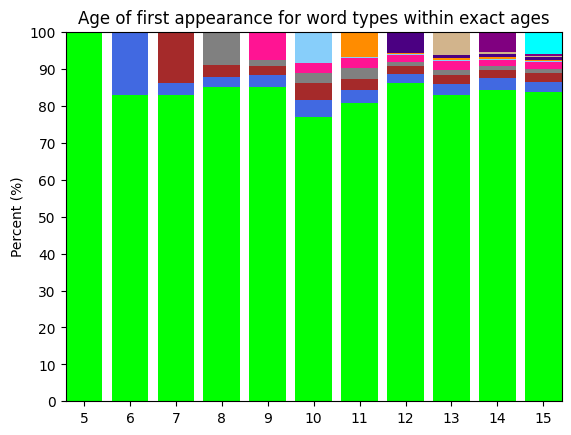

In [16]:
aoa_proportions_ages = getAoAInfo(dfs_ages, False, True)
test = [[aoa_proportions_ages[y][x] for x in range(5,16)] for y in aoa_proportions_ages]
for t in test:
    t.reverse()
y = np.column_stack(test)
x = range(5,16)


# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y * 100 
fig = plt.figure()
ax = fig.add_subplot(111)

totals = np.zeros(11)
for i in range(len(percent)-1, -1, -1):
    current = [y for y in percent[i]]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[::-1][i])
    totals = np.add(totals, current)


#ax.stackplot(x, percent, labels=PLOT_AGES[::-1], colors=PLOT_COLORS)
ax.set_title('Age of first appearance for word types within exact ages')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x)
ax.set_yticks(range(0,110,10))
#ax.legend(PLOT_AGES[::-1])
plt.show()

{'7-8': Counter({5: 2733510, 7: 131401, 6: 118088, 8: 81111}), '9-12': Counter({5: 6947028, 9: 324910, 6: 225366, 7: 187192, 12: 140510, 8: 119135, 10: 65851, 11: 35145}), '13+': Counter({5: 6022108, 6: 166945, 7: 141002, 14: 138744, 15: 117358, 9: 112636, 13: 100904, 8: 65019, 12: 40154, 11: 26287, 10: 16857})}
{'7-8': {5: 0.892, 6: 0.039, 7: 0.043, 8: 0.026}, '9-12': {5: 0.864, 6: 0.028, 7: 0.023, 8: 0.015, 9: 0.04, 10: 0.008, 11: 0.004, 12: 0.017}, '13+': {5: 0.867, 6: 0.024, 7: 0.02, 8: 0.009, 9: 0.016, 10: 0.002, 11: 0.004, 12: 0.006, 13: 0.015, 14: 0.02, 15: 0.017}}
{'7-8': {5: 0.892, 6: 0.039, 7: 0.043, 8: 0.026, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0}, '9-12': {5: 0.864, 6: 0.028, 7: 0.023, 8: 0.015, 9: 0.04, 10: 0.008, 11: 0.004, 12: 0.017, 13: 0.0, 14: 0.0, 15: 0.0}, '13+': {5: 0.867, 6: 0.024, 7: 0.02, 8: 0.009, 9: 0.016, 10: 0.002, 11: 0.004, 12: 0.006, 13: 0.015, 14: 0.02, 15: 0.017}}


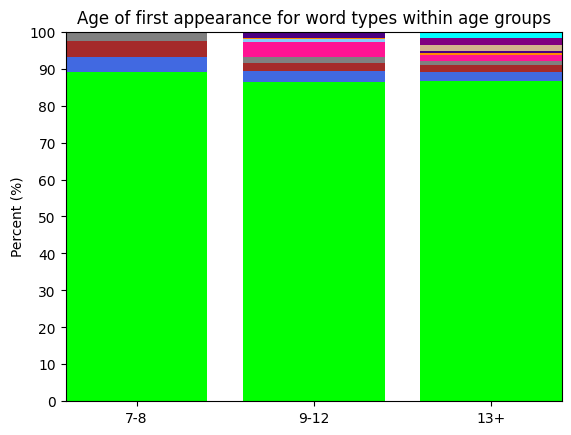

In [17]:
aoa_proportions_groups = getAoAInfo(dfs_groups, False, True)
test = [[aoa_proportions_groups[y][x] for x in range(5,16)] for y in aoa_proportions_groups]
#for t in test:
#    t.reverse()

y = np.column_stack(test)
x = range(0,3)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 
fig = plt.figure()
ax = fig.add_subplot(111)
totals = np.zeros(len(x))
for i in range(len(percent)):
    current = [percent[i][y] for y in range(len(x))]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[i])
    totals = np.add(totals, current)


ax.set_title('Age of first appearance for word types within age groups')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x, labels=SHEET_NAMES_GROUPS)
ax.set_yticks(range(0,110,10))
plt.show()

{'Whole': Counter({5: 18442426, 6: 546481, 7: 490328, 9: 447697, 8: 280454, 12: 183972, 14: 138743, 15: 117358, 13: 100904, 10: 84217, 11: 62699})}
{'Whole': {5: 0.883, 6: 0.026, 7: 0.023, 8: 0.013, 9: 0.021, 10: 0.004, 11: 0.003, 12: 0.009, 13: 0.005, 14: 0.007, 15: 0.006}}
{'Whole': {5: 0.883, 6: 0.026, 7: 0.023, 8: 0.013, 9: 0.021, 10: 0.004, 11: 0.003, 12: 0.009, 13: 0.005, 14: 0.007, 15: 0.006}}


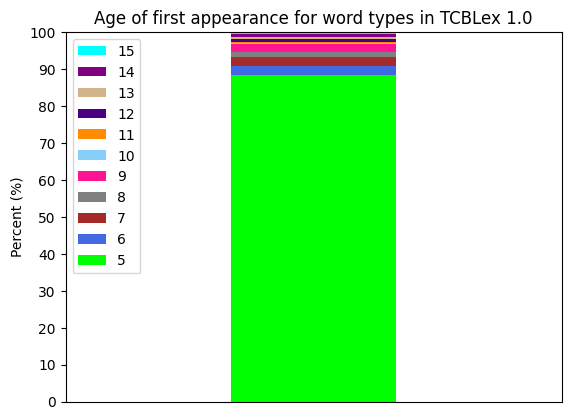

In [18]:
aoa_proportions_whole = getAoAInfo(dfs_whole, False, True)
test = [[aoa_proportions_whole[y][x] for x in range(5,16)] for y in aoa_proportions_whole]

y = np.column_stack(test)
x = range(0,1)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

totals = np.zeros(len(x))
for i in range(len(percent)):
    current = [percent[i][0]]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[i], width=0.5)
    totals = np.add(totals, current)

ax.set_title('Age of first appearance for word types in TCBLex 1.0')
ax.set_ylabel('Percent (%)')
ax.margins(1, 0) # Set margins to avoid "whitespace"
ax.set_yticks(range(0,110,10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.legend(reverse=True, labels=PLOT_AGES, loc='upper left')
plt.show()

Zipf-values

In [28]:
import math
def plot_zipf(data: dict[str,pd.Series], column: str, dupe_col: str):
    per_row = math.ceil(math.sqrt(len(data)))
    fig, axs = plt.subplots(per_row, per_row)
    keys = list(data.keys())
    y_range = [np.inf,-np.inf]
    x_range = [np.inf,-np.inf]
    
    for i in range(len(keys)):
        x = i % per_row
        y = math.floor(i / per_row)
        to_plot = data[keys[i]].drop_duplicates(dupe_col)[column]
        bins = np.linspace(np.min(to_plot), np.max(to_plot), 24) - 0.5
        axs[y, x].hist(to_plot.to_numpy(), bins=bins)
        #axs[y, x].set_xticks(np.linspace(np.min(to_plot), np.max(to_plot) , 5) - 0.5)
        axs[y, x].set_title(keys[i])
        per_50 = np.percentile(to_plot, 50)
        per_75 = np.percentile(to_plot, 75)
        per_90 = np.percentile(to_plot, 90)
        axs[y, x].axvline(per_50, color='r', linestyle='dashed', linewidth=1, label='50th Percentile')
        axs[y, x].axvline(per_75, color='r', linestyle='dashed', linewidth=1, label='75th Percentile')
        axs[y, x].axvline(per_90, color='r', linestyle='dashed', linewidth=1, label='90th Percentile')
    for ax in axs.flat:
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        if x_lim[0] < x_range[0]:
            x_range[0] = x_lim[0]
        if x_lim[1] > x_range[1]:
            x_range[1] = x_lim[1]
        if y_lim[0] < y_range[0]:
            y_range[0] = y_lim[0]
        if y_lim[1] > y_range[1]:
            y_range[1] = y_lim[1]
        ax.set_ylim(0,)
        ax.label_outer()

    for ax in axs.flat:
        ax.set_ylim(y_range)
        ax.set_xlim(x_range)
        space = np.linspace(x_range[0], x_range[1], 4, dtype=int)
        space = np.delete(space, 0)
        ax.set_xticks(space - 0.5)
        ax.label_outer()
        

    return fig, axs

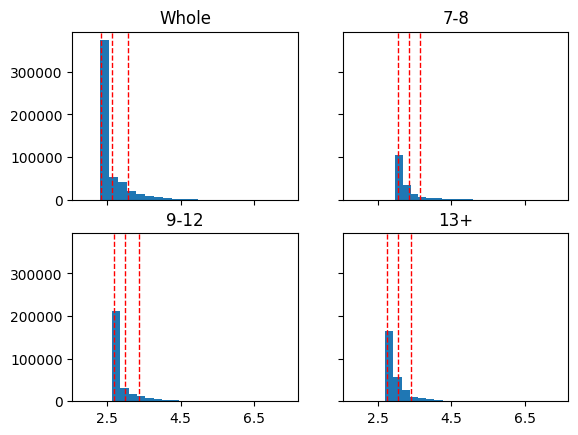

In [29]:
grpwh = bdf.combineSubCorpDicts([dfs_whole, dfs_groups])
fig, axs = plot_zipf(grpwh, 'Word Zipf', 'text')

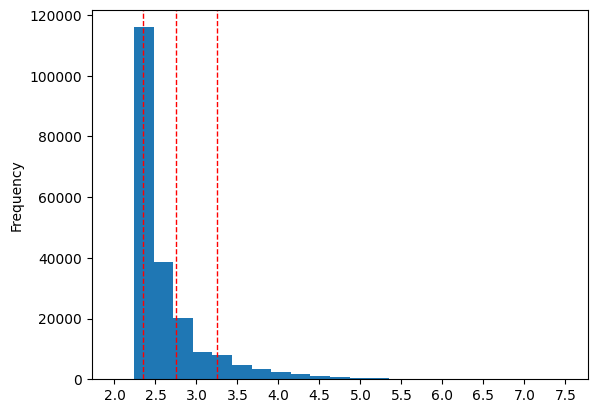

In [21]:
lemma_zipfs = dfs_whole['Whole'].drop_duplicates('lemma')['Lemma Zipf']

bins = np.linspace(2.5, 8 ,24) - 0.5
ax = lemma_zipfs.plot.hist(bins=bins)
ax.set_xticks(np.linspace(2.5, 8 ,12) - 0.5)
per_60 = np.percentile(lemma_zipfs.values, 50)
per_80 = np.percentile(lemma_zipfs.values, 75)
per_90 = np.percentile(lemma_zipfs.values, 90)
ax.axvline(per_60, color='r', linestyle='dashed', linewidth=1, label='50th Percentile')
ax.axvline(per_80, color='r', linestyle='dashed', linewidth=1, label='75th Percentile')
ax.axvline(per_90, color='r', linestyle='dashed', linewidth=1, label='90th Percentile')

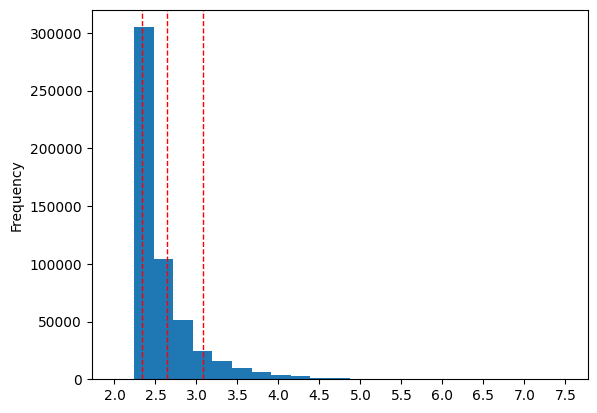

In [22]:
word_zipfs = dfs_whole['Whole'].drop_duplicates('text')['Word Zipf']

bins = np.linspace(2.5, 8 ,24) - 0.5
ax = word_zipfs.plot.hist(bins=bins)
ax.set_xticks(np.linspace(2.5, 8 ,12) - 0.5)
per_60 = np.percentile(word_zipfs.values, 50)
per_80 = np.percentile(word_zipfs.values, 75)
per_90 = np.percentile(word_zipfs.values, 90)
ax.axvline(per_60, color='r', linestyle='dashed', linewidth=1, label='50th Percentile')
ax.axvline(per_80, color='r', linestyle='dashed', linewidth=1, label='75th Percentile')
ax.axvline(per_90, color='r', linestyle='dashed', linewidth=1, label='90th Percentile')

D, U ,and SFI stuffs

In [23]:
temp = list(formatStatisticalData(dfs_whole, 'Word CD', WHOLE).values())
#temp.sort()
for i in temp:
    print(i)

M & 0.018 \\
SD & 0.055 \\
Min & 0.004 \\
P10 & 0.004 \\
P25 & 0.004 \\
P50 & 0.004 \\
P75 & 0.008 \\
P90 & 0.03 \\
Max & 1.0 \\


<Axes: ylabel='Frequency'>

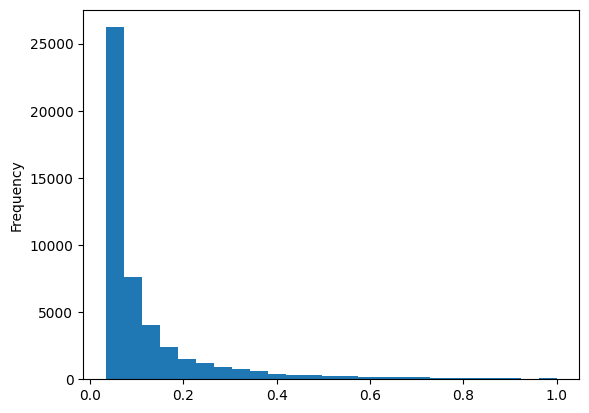

In [24]:
bins = np.linspace(-10, 100 , 12) - 0.5
dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] > 0.03].drop_duplicates('text')['Word CD'].plot.hist(bins=25)

In [25]:
temp = list(formatStatisticalData(dfs_groups, 'Lemma IFS', SHEET_NAMES_GROUPS).values())
#temp.sort()
for i in temp:
    print(i)

M & 2.381 & 2.601 & 2.566 \\
SD & 4.615 & 5.41 & 5.28 \\
Min & 1 & 1 & 1 \\
P10 & 1.0 & 1.0 & 1.0 \\
P25 & 1.0 & 1.0 & 1.0 \\
P50 & 1.0 & 1.0 & 1.0 \\
P75 & 2.0 & 2.0 & 2.0 \\
P90 & 4.0 & 5.0 & 5.0 \\
Max & 208 & 246 & 241 \\


In [26]:
temp = list(formatStatisticalData(dfs_whole, 'Lemma IFS', WHOLE).values())
#temp.sort()
for i in temp:
    print(i)

M & 2.528 \\
SD & 5.599 \\
Min & 1 \\
P10 & 1.0 \\
P25 & 1.0 \\
P50 & 1.0 \\
P75 & 2.0 \\
P90 & 5.0 \\
Max & 290 \\


Inflectional family size plot

([<matplotlib.axis.XTick at 0x75f0b0c5f7c0>,
 [Text(1, 0, '7-8'), Text(2, 0, '9-12'), Text(3, 0, '13+')])

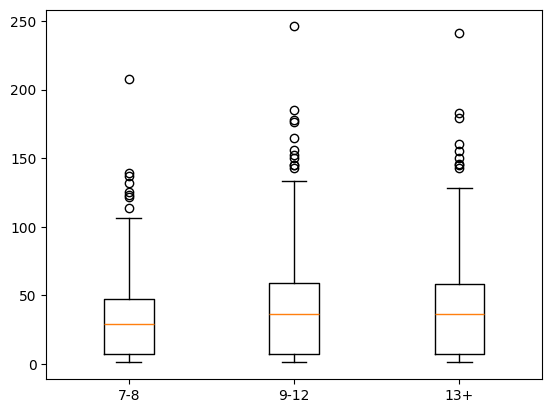

In [27]:
grpwh = dfs_groups

datt = [grpwh[sheet][(grpwh[sheet]['Lemma F'] > np.percentile(grpwh[sheet]['Lemma F'], 90))].drop_duplicates('lemma')['Lemma IFS'].to_numpy() for sheet in grpwh]
plt.boxplot(datt)
plt.xticks([1,2,3], labels=list(grpwh.keys()))

In [39]:
#In how many books

print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] < 0.005].drop_duplicates('lemma')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] > 0.49].drop_duplicates('lemma')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] == 1].drop_duplicates('lemma')))
print(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] == 1].drop_duplicates('lemma')['Lemma F'].sum()/dfs_whole['Whole'].drop_duplicates('lemma')['Lemma F'].sum())

136062
1616
13
0.28230479196661795


In [38]:
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] < 0.005].drop_duplicates('text')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] > 0.49].drop_duplicates('text')))
print(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] == 1].drop_duplicates('text')['Word F'].sum()/dfs_whole['Whole'].drop_duplicates('text')['Word F'].sum())

337102
1889
0.1934015374085347
